
## <p style="text-align: center;"> SARIMAX Time Series Model to Forecast US Home Sales

### SARIMAX = Seasonal Auto-Regressive Integrated Moving Average with eXogenous variables
<br>
Seasonal - patterns in the data that are tied to specific times of the year<br>
<br>
Auto-Regressive - assumes past values have an effect on future values<br>
<br>
Integrated - use of differencing between current values and past values to ensure a necessary feature of time series models: stationarity<br>
<br>
Moving Average - the lag of residuals; the part of the model that is not explained by trend or seasonality<br>
<br>
Exogenous variables - outside variables for the model to consider (i.e. mortgage rates, housing inventory, etc.)<br>
<br>

In [4]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [5]:
## Import the necessary packages. If you are missing any packages, then run the prerequiste.py file in the repo
import pandas as pd
from openpyxl import workbook
from fredapi import Fred
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import statsmodels.api as sm
import numpy as np
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from numpy import array

In [2]:
## You'll need to generate a key for this step. Once you have a key, create a text file and put the path inside of the quotes. Use key to access FRED api,
with open(r"C:\Users\Matt\Documents\home sales & rates\key.txt") as f:
   key = f.read()

fred = Fred(key)


In [6]:
HomeSales = pd.read_excel(r'Historical_Home_Sales_March2022.xlsx').set_index(['Date'])
Exist = pd.DataFrame(fred.get_series('EXHOSLUSM495N')).rename(columns={0:'ExistingHS'})
NewHS = pd.DataFrame(fred.get_series('HSN1FNSA')).rename(columns={0:'NewHS'})
Rates = pd.DataFrame(fred.get_series('MORTGAGE30US')).rename(columns={0:'Rates'})
PenList = pd.DataFrame(fred.get_series('PENLISCOUUS')).rename(columns={0:'PendingLists'})
ActList = pd.DataFrame(fred.get_series('ACTLISCOUUS')).rename(columns={0:'ActiveLists'})
CaseSchuller = pd.DataFrame(fred.get_series('CSUSHPISA')).rename(columns={0:'CS_Index'})
NewComp = pd.DataFrame(fred.get_series('COMPUTNSA')).rename(columns={0:'NewComps'})
NewConst = pd.DataFrame(fred.get_series('UNDCONTNSA')).rename(columns={0:'NewConst'})
NewPerm = pd.DataFrame(fred.get_series('PERMITNSA')).rename(columns={0:'NewPerms'})
NewStart = pd.DataFrame(fred.get_series('HOUSTNSA')).rename(columns={0:'NewStarts'})
UnEm25_AD = pd.DataFrame(fred.get_series('CGMD25O')).rename(columns={0:'UnEm25_AD'})
UnEm25_BD = pd.DataFrame(fred.get_series('LNU04027662')).rename(columns={0:'UnEm25_BD'})
UnEm25_MD = pd.DataFrame(fred.get_series('CGMD25O')).rename(columns={0:'UnEm25_MD'})
GS10 = pd.DataFrame(fred.get_series('GS10')).rename(columns={0:'GS10'})
GS5 = pd.DataFrame(fred.get_series('GS5')).rename(columns={0:'GS5'})
GS1 = pd.DataFrame(fred.get_series('GS1')).rename(columns={0:'GS1'})
GS3M = pd.DataFrame(fred.get_series('GS3M')).rename(columns={0:'GS3M'})
MDOM = pd.DataFrame(fred.get_series('MEDDAYONMARUS')).rename(columns={0:'MedDayOnMar'})
MHSP = pd.DataFrame(fred.get_series('MSPNHSUS')).rename(columns={0:'MedHomeSalePrice'})
RPCE = pd.DataFrame(fred.get_series('PCEC96')).rename(columns={0:'RealPCE'})

In [7]:
df = pd.merge(Exist,NewHS, left_index=True, right_index=True)
df['NewHS'] = df['NewHS'] * 1000
df['HomeSales'] = df['ExistingHS'] + df['NewHS']
TotalHS = pd.merge(HomeSales,df,left_index=True,right_index=True,how='outer')
TotalHS['HomeSales'] = TotalHS['HomeSales_x'].fillna(TotalHS['HomeSales_y'])
TotalHS = TotalHS[['HomeSales']]
    
Rates = pd.DataFrame(Rates.groupby(pd.PeriodIndex(Rates.index, freq="M"))['Rates'].mean())
Rates.index = pd.PeriodIndex(Rates.index, freq='M').to_timestamp()
try:
    NewComp['NewComps'] = NewComp['NewComps'] * 1000
    NewConst['NewConst'] = NewConst['NewConst'] * 1000
    NewPerm['NewPerms'] = NewPerm['NewPerms'] * 1000
    NewStart['NewStarts'] = NewStart['NewStarts'] * 1000
except:
    print('Error converting units')



In [214]:
final = TotalHS.merge(Rates,left_index=True,right_index=True)
final = final.merge(PenList,left_index=True,right_index=True)
final = final.merge(NewComp,left_index=True,right_index=True)
final = final.merge(ActList,left_index=True,right_index=True)
#final = final.merge(CaseSchuller,left_index=True,right_index=True,how='outer')
final = final.merge(NewConst,left_index=True,right_index=True)
final = final.merge(NewPerm,left_index=True,right_index=True)
final = final.merge(NewStart,left_index=True,right_index=True)
final = final.merge(UnEm25_BD,left_index=True,right_index=True)
final = final.merge(GS10,left_index=True,right_index=True)
final = final.merge(GS5,left_index=True,right_index=True)
final = final.merge(GS1,left_index=True,right_index=True)
final = final.merge(GS3M,left_index=True,right_index=True)
final = final.merge(MDOM,left_index=True,right_index=True)
final = final.merge(MHSP,left_index=True,right_index=True)
final = final.merge(RPCE,left_index=True,right_index=True)
final

,HomeSales,Rates,PendingLists,NewComps,ActiveLists,NewConst,NewPerms,NewStarts,UnEm25_BD,GS10,GS5,GS1,GS3M,MedDayOnMar,MedHomeSalePrice,RealPCE
2017-01-01,364000.0,4.1500,267961.0,74600.0,1154365.0,1045800.0,90600.0,82300.0,2.5,2.43,1.92,0.83,0.52,96.0,315200.0,12352.7
2017-02-01,366000.0,4.1675,319484.0,78900.0,1151363.0,1051100.0,86900.0,87800.0,2.4,2.42,1.90,0.82,0.53,92.0,298000.0,12351.0
2017-03-01,516000.0,4.1960,372081.0,92000.0,1172985.0,1052600.0,115300.0,97100.0,2.4,2.48,2.01,1.01,0.75,70.0,321700.0,12405.9
2017-04-01,503000.0,4.0450,425785.0,83400.0,1195028.0,1071400.0,105000.0,105200.0,2.3,2.30,1.82,1.04,0.81,65.0,311100.0,12402.2
2017-05-01,612000.0,4.0100,453030.0,98100.0,1250195.0,1077500.0,115300.0,106000.0,2.1,2.30,1.84,1.12,0.90,61.0,323600.0,12409.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,414000.0,6.9000,415816.0,118100.0,750653.0,1726700.0,120800.0,121600.0,1.8,3.98,4.18,4.43,3.87,51.0,496800.0,14263.3
2022-11-01,366000.0,6.8050,369954.0,125100.0,748344.0,1705800.0,102500.0,111100.0,1.9,3.89,4.06,4.73,4.32,56.0,462300.0,14204.3
2022-12-01,374000.0,6.3640,321415.0,132000.0,679650.0,1666500.0,104400.0,94700.0,1.7,3.62,3.76,4.68,4.36,66.0,479500.0,14176.9
2023-01-01,288000.0,6.2725,302572.0,94800.0,615805.0,1670100.0,101000.0,97700.0,2.1,3.53,3.64,4.69,4.69,74.0,428500.0,14382.9


rate_df = pd.merge(Rates,GS10,left_index=True,right_index=True)
rate_df = rate_df.merge(GS5,left_index=True,right_index=True)
rate_df = rate_df.merge(GS1,left_index=True,right_index=True)
rate_df = rate_df.merge(GS3M,left_index=True,right_index=True)

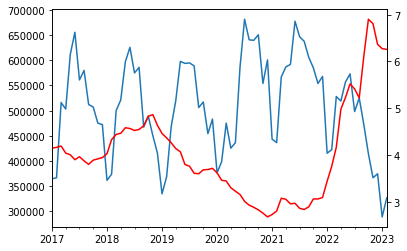

In [215]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['Rates'].plot(c='red')

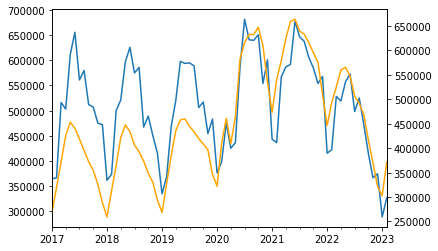

In [216]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['PendingLists'].plot(c='orange')

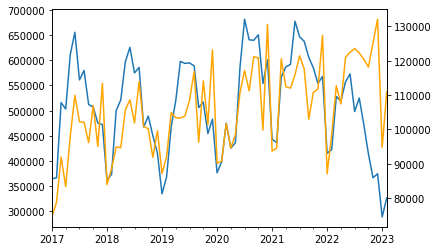

In [217]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['NewComps'].plot(c='orange')

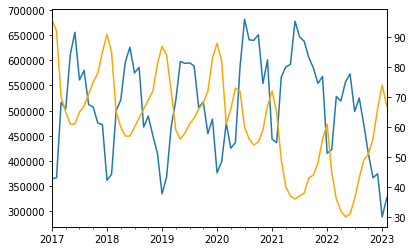

In [218]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['MedDayOnMar'].plot(c='orange')

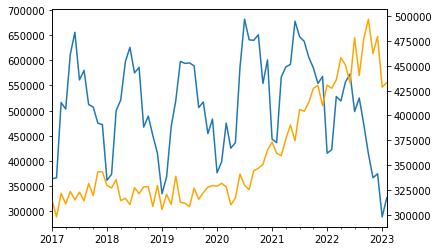

In [219]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['MedHomeSalePrice'].plot(c='orange')

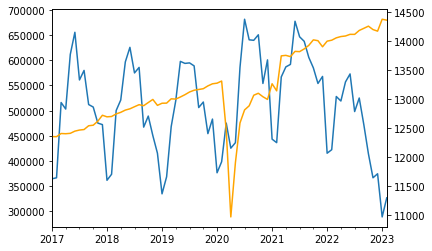

In [220]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['RealPCE'].plot(c='orange')

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-6.0851421219918596,
 1.0688547859170788e-07,
 12,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 1445.3259904190663)

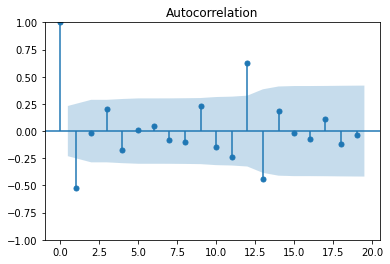

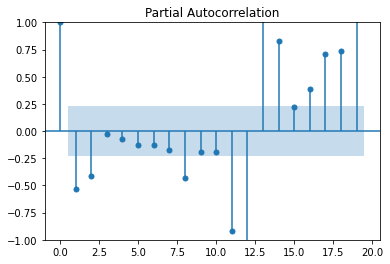

In [221]:
final['HS_1Diff'] = final['HomeSales'] - final['HomeSales'].shift(1)
final['HS_2Diff'] = final['HS_1Diff'] - final['HS_1Diff'].shift(1)
fig1=plot_acf(final['HS_2Diff'].dropna()) 
fig2=plot_pacf(final['HS_2Diff'].dropna())
result = adfuller(final.HS_2Diff.dropna())
result

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-8.087346165112638,
 1.40820949572669e-12,
 3,
 68,
 {'1%': -3.530398990560757,
  '5%': -2.9050874099328317,
  '10%': -2.5900010121107266},
 -17.096000456790932)

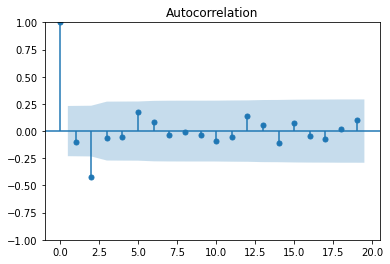

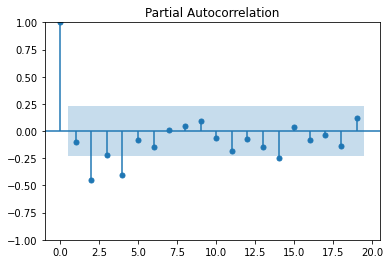

In [222]:
final['Rates_1D'] = final['Rates'] - final['Rates'].shift(1) 
final['Rates_2D'] = final['Rates_1D'] - final['Rates_1D'].shift(1)
fig1=plot_acf(final['Rates_2D'].dropna()) 
fig2=plot_pacf(final['Rates_2D'].dropna())
result = adfuller(final['Rates_2D'].dropna())
result

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-7.740767720709702,
 1.0634485921243014e-11,
 10,
 61,
 {'1%': -3.542412746661615,
  '5%': -2.910236235808284,
  '10%': -2.5927445767266866},
 1396.7589674798473)

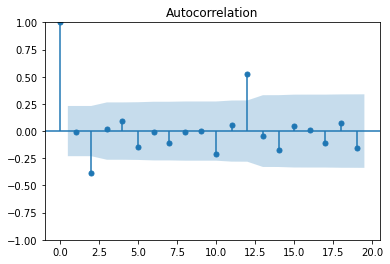

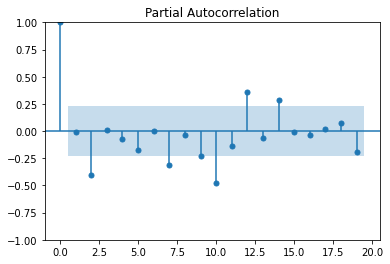

In [223]:
final['PL_1Diff'] = final['PendingLists'] - final['PendingLists'].shift(1) 
final['PL_2Diff'] = final['PL_1Diff'] - final['PL_1Diff'].shift(1) 
result = adfuller(final['PL_2Diff'].dropna())
fig1=plot_acf(final['PL_2Diff'].dropna()) 
fig2=plot_pacf(final['PL_2Diff'].dropna())
result

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-7.522805406423073,
 3.751918727813647e-11,
 9,
 62,
 {'1%': -3.540522678829176,
  '5%': -2.9094272025108254,
  '10%': -2.5923136524453696},
 1364.7070872860597)

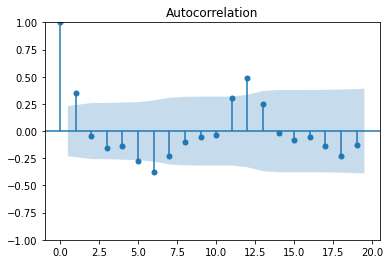

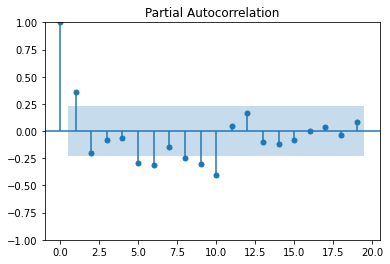

In [224]:
final['AL_1Diff'] = final['ActiveLists'] - final['ActiveLists'].shift(1) 
final['AL_2Diff'] = final['AL_1Diff'] - final['AL_1Diff'].shift(1)
fig1=plot_acf(final['AL_2Diff'].dropna()) 
fig2=plot_pacf(final['AL_2Diff'].dropna())
result = adfuller(final['AL_2Diff'].dropna())
result

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-4.263976522766371,
 0.0005125326535548713,
 11,
 61,
 {'1%': -3.542412746661615,
  '5%': -2.910236235808284,
  '10%': -2.5927445767266866},
 1266.1922301561688)

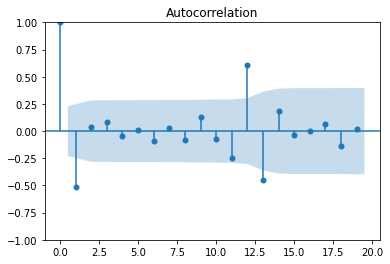

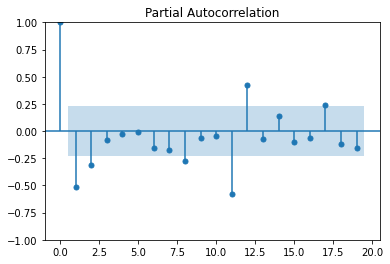

In [225]:
final['NC_1Diff'] = final['NewComps'] - final['NewComps'].shift(1) 
result = adfuller(final['NC_1Diff'].dropna())
fig1=plot_acf(final['NC_1Diff'].dropna()) 
fig2=plot_pacf(final['NC_1Diff'].dropna())
result

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-4.9414438316237765,
 2.8943650454504556e-05,
 12,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 1291.5817998868538)

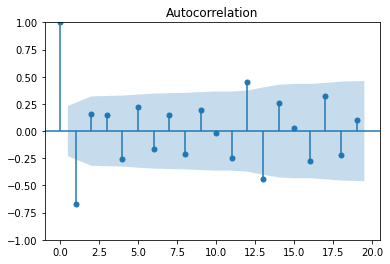

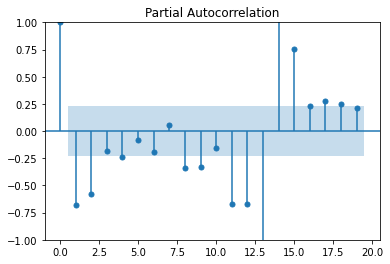

In [226]:
final['NP_1Diff'] = final['NewPerms'] - final['NewPerms'].shift(1) 
final['NP_2Diff'] = final['NP_1Diff'] - final['NP_1Diff'].shift(1) 
result = adfuller(final['NP_2Diff'].dropna())
fig1=plot_acf(final['NP_2Diff'].dropna()) 
fig2=plot_pacf(final['NP_2Diff'].dropna())
result

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-3.0417050791845486,
 0.031178991206508706,
 0,
 73,
 {'1%': -3.5232835753964475,
  '5%': -2.902030597326081,
  '10%': -2.5883710883843123},
 1314.7276151837816)

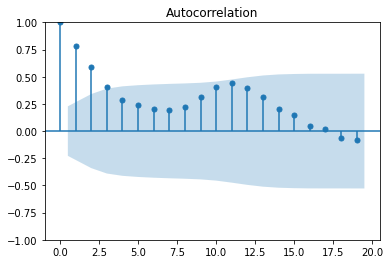

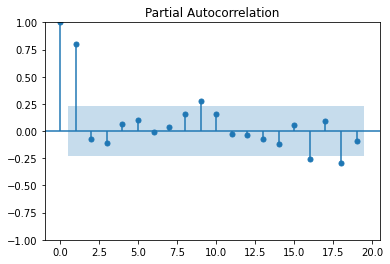

In [227]:
result = adfuller(final.NewStarts.dropna())
fig1=plot_acf(final['NewStarts'].dropna()) 
fig2=plot_pacf(final['NewStarts'].dropna())
result

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-8.584729061858699,
 7.561092591872963e-14,
 0,
 72,
 {'1%': -3.524624466842421,
  '5%': -2.9026070739026064,
  '10%': -2.5886785262345677},
 153.99652598258484)

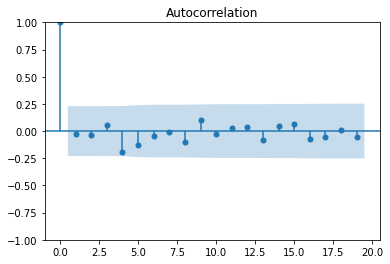

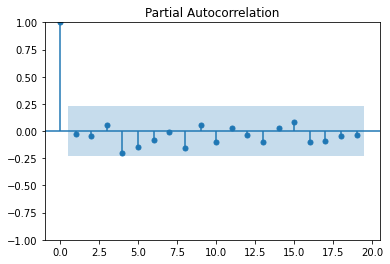

In [228]:
final['UEBD25_1D'] = final['UnEm25_BD'] - final['UnEm25_BD'].shift(1) 
result = adfuller(final['UEBD25_1D'].dropna())
fig1=plot_acf(final['UEBD25_1D'].dropna()) 
fig2=plot_pacf(final['UEBD25_1D'].dropna())
result

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-8.505441857344612,
 1.2064330950291057e-13,
 10,
 61,
 {'1%': -3.542412746661615,
  '5%': -2.910236235808284,
  '10%': -2.5927445767266866},
 365.58044035918675)

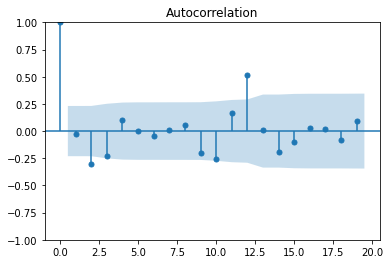

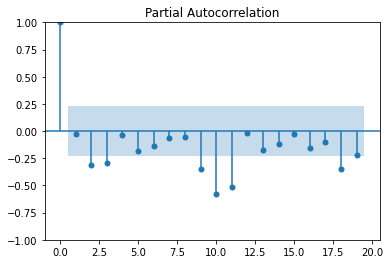

In [229]:
final['MDOM_1D'] = final['MedDayOnMar'] - final['MedDayOnMar'].shift(1) 
final['MDOM_2D'] = final['MDOM_1D'] - final['MDOM_1D'].shift(1) 
result = adfuller(final['MDOM_2D'].dropna())
fig1=plot_acf(final['MDOM_2D'].dropna()) 
fig2=plot_pacf(final['MDOM_2D'].dropna())
result

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-15.14202493271896,
 6.98892865238543e-28,
 0,
 72,
 {'1%': -3.524624466842421,
  '5%': -2.9026070739026064,
  '10%': -2.5886785262345677},
 1332.9301183811313)

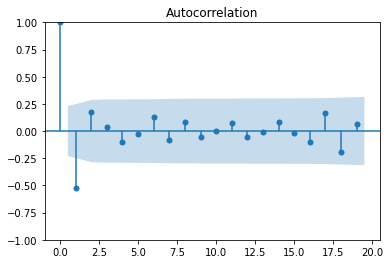

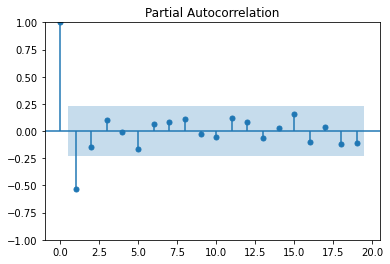

In [230]:
final['MHSP_1D'] = final['MedHomeSalePrice'] - final['MedHomeSalePrice'].shift(1) 
result = adfuller(final['MHSP_1D'].dropna())
fig1=plot_acf(final['MHSP_1D'].dropna()) 
fig2=plot_pacf(final['MHSP_1D'].dropna())
result

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-7.663587000804408,
 1.6636981988409774e-11,
 1,
 71,
 {'1%': -3.526004646825607,
  '5%': -2.9032002348069774,
  '10%': -2.5889948363419957},
 848.7534157912385)

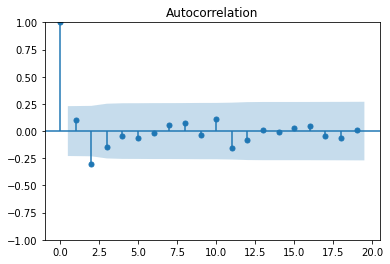

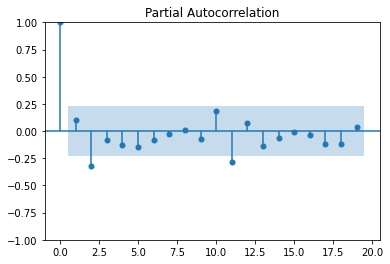

In [231]:
final['RPCE_1D'] = final['RealPCE'] - final['RealPCE'].shift(1)
fig1=plot_acf(final['RPCE_1D'].dropna()) 
fig2=plot_pacf(final['RPCE_1D'].dropna())
result = adfuller(final['RPCE_1D'].dropna())
result

In [573]:
final_na = final.dropna()
X_train = final_na.drop(['HomeSales','HS_1Diff','HS_2Diff'],axis=1)[:-18]
y_train = final_na[['HomeSales','HS_1Diff','HS_2Diff']][:-18]
X_test = final_na.drop(['HomeSales','HS_1Diff','HS_2Diff'],axis=1)[-18:]
y_test = final_na[['HomeSales','HS_1Diff','HS_2Diff']][-18:]


In [603]:

X = X_train[['Rates','PendingLists','ActiveLists','NewComps','NewPerms','NewStarts','UnEm25_BD','MedDayOnMar','MedHomeSalePrice','RealPCE']]
#X = X_train[['Rates_2D','PL_2Diff','AL_2Diff','NC_1Diff','NP_2Diff','NewStarts','UEBD25_1D','MDOM_2D','MHSP_1D','RPCE_1D']]
y = y_train['HomeSales']
#y = y_train['HS_2Diff']
estimator = RandomForestRegressor(n_estimators=5000, random_state=1)
#estimator = GradientBoostingRegressor(n_estimators=5000, random_state=1)
selector = RFE(estimator, n_features_to_select=9, step=1)
selector = selector.fit(X, y)

In [604]:
filter = selector.support_
ranking = selector.ranking_

print("Mask data: ", filter)
print("Ranking: ", ranking) 
print(selector.feature_names_in_)
print("Selected features:")
print("Score:", selector.score(X,y))

Mask data:  [ True  True  True  True  True  True  True  True False  True]
Ranking:  [1 1 1 1 1 1 1 1 2 1]
['Rates' 'PendingLists' 'ActiveLists' 'NewComps' 'NewPerms' 'NewStarts'
 'UnEm25_BD' 'MedDayOnMar' 'MedHomeSalePrice' 'RealPCE']
Selected features:
Score: 0.966845373135467


In [1]:

arr1 = np.array(X_train[['Rates','PendingLists','ActiveLists','NewComps','NewPerms','NewStarts','UnEm25_BD','MedDayOnMar','RealPCE']]).reshape(-1,9)
arr2 = np.array(y_train['HomeSales']).reshape(-1,1)
stepwise_fit = auto_arima(arr2,arr1, start_p = 0, start_q = 0,
                          max_p = 3, max_q = 3, m = 3,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
stepwise_fit.summary()

NameError: name 'np' is not defined

In [606]:
## from statsmodels.tsa.statespace.sarimax import SARIMAX
model=sm.tsa.SARIMAX(y_train['HomeSales'],X_train[['Rates','PendingLists','ActiveLists','NewComps','NewPerms','NewStarts','UnEm25_BD','MedDayOnMar','RealPCE']],order=(0,1,1),seasonal_order=(0, 1, 1, 12))
result=model.fit()
result.summary()

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          HomeSales   No. Observations:                   54
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -461.045
Date:                            Tue, 25 Apr 2023   AIC                            946.090
Time:                                    16:49:08   BIC                            966.653
Sample:                                03-01-2017   HQIC                           953.578
                                     - 08-01-2021                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Rates        -6469.9921   2.78e+04     -0.232      0.816    -6.1e+04    4.81e+04
PendingLists     0.5665      0.207      2.740      0.006       0.161       0.972
ActiveLists      0.2060      0.102      2.015      0.044       0.006       0.406
NewComps         1.2162      1.204      1.010      0.312      -1.143       3.576
NewPerms         1.1370      0.805      1.413      0.158      -0.440       2.714
NewStarts        1.3534      0.894      1.514      0.130      -0.398       3.105
UnEm25_BD     1.624e+04   9480.881      1.713      0.087   -2343.009    3.48e+04
MedDayOnMar  -3622.8988   1920.031     -1.887      0.059   -7386.090     140.293
RealPCE         -0.9626     25.951     -0.037      0.970     -51.826      49.900
ma.L1           -0.7987      0.335     -2.386      0.017      -1.455      -0.143
ma.S.L12        -0.4330      0.338     -1.283      0.200      -1.095       0.229
sigma2        4.893e+08      0.895   5.47e+08      0.000    4.89e+08    4.89e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.68   Prob(JB):                         0.53
Heteroskedasticity (H):               0.34   Skew:                            -0.42
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.17e+24. Standard errors may be unstable.
"""

<AxesSubplot:ylabel='Density'>

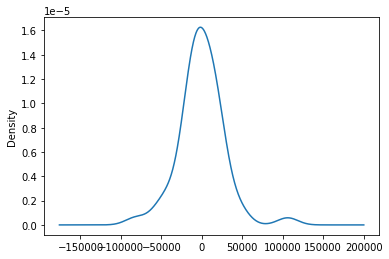

In [607]:
result.resid.plot(kind='kde')


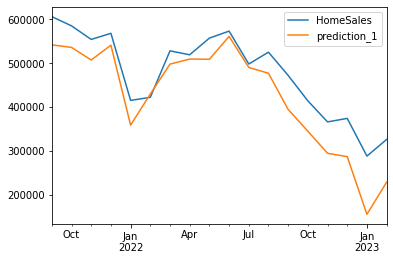

In [609]:
excog_fore = X_test[['Rates','PendingLists','ActiveLists','NewComps','NewPerms','NewStarts','UnEm25_BD','MedDayOnMar','RealPCE']]
y_test['prediction_1']=pd.DataFrame(result.predict(start=len(X_train), end=len(final_na[:-1]),exog=excog_fore))
result.summary()
y_test[['HomeSales','prediction_1']].plot()
                                  
model_result = y_test[['HomeSales','prediction_1']]
#df2['Version'] = input("Version #")

In [557]:
pca = PCA(n_components=4)
pca_features = pca.fit_transform(final_na[['Rates_2D','PL_2Diff','AL_2Diff','NC_1Diff','NP_2Diff','NewStarts','UEBD25_1D','MDOM_2D','MHSP_1D','RPCE_1D']])
pca_df = pd.DataFrame(pca_features)
pca_df['y'] = final_na['HomeSales'].reset_index(drop=True)
pca_df.head()

,0,1,2,3,y
0,11120.010063,21333.042679,-29873.997682,-7035.996792,516000.0
1,399.369498,-2599.621304,37017.059957,19212.148828,503000.0
2,-13830.028033,38374.982006,-21939.511343,149.274878,612000.0
3,-42852.756304,-3290.608185,-12094.117943,6347.381334,656000.0
4,-12678.598003,-5901.482505,43299.087963,1234.805966,561000.0


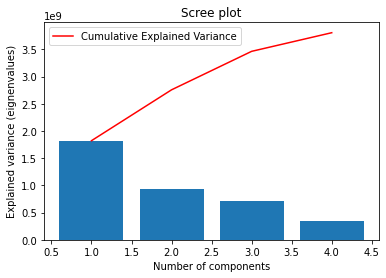

In [558]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

In [559]:
pca = PCA(n_components=3)
pca_features = pca.fit_transform(final_na[['Rates','PendingLists','ActiveLists','NewComps','NewPerms','NewStarts','UnEm25_BD','MedDayOnMar','MedHomeSalePrice','RealPCE']])

pca_df = pd.DataFrame(pca_features, columns=['PCA1','PCA2','PCA3'])
pca_df['y'] = final_na['HomeSales'].reset_index(drop=True)
pca_df.head()

,PCA1,PCA2,PCA3,y
0,-291806.044880,18247.006708,-9561.485027,516000.0
1,-302558.861283,-38645.805715,-10277.397937,503000.0
2,-347468.993394,-74916.479386,17556.182259,612000.0
3,-387458.270052,-75597.622777,19367.281078,656000.0
4,-422425.481938,-56096.330878,24541.972165,561000.0


In [560]:
X_train = pca_df[['PCA1','PCA2','PCA3']][:-18]
y_train = pca_df[['y']][:-18]
X_test = pca_df[['PCA1','PCA2','PCA3']][-18:]
y_test = pca_df[['y']][-18:]

In [561]:
arr1 = np.array(X_train).reshape(-1,3)
arr2 = np.array(y_train).reshape(-1,1)
stepwise_fit = auto_arima(arr2,arr1, start_p = 0, start_q = 0,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1003.641, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1001.647, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1005.606, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1005.055, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1121.631, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1003.645, Time=0.13 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1002.926, Time=0.51 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1003.745, Time=0.06 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1003.070, Time=0.09 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=999.514, Time=0.26 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1001.485, Time=0.53 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1001.479, Time=0.54 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=999.433, Time=0.18 sec
 ARIMA(2,0,1)(1,1,0)[12] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   54
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -486.655
Date:                            Tue, 25 Apr 2023   AIC                            995.311
Time:                                    14:56:29   BIC                           1014.425
Sample:                                         0   HQIC                          1002.317
                                             - 54                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7285.4055   3.82e+04     -0.191      0.849   -8.21e+04    6.75e+04
x1             0.3026      0.175      1.726      0.084      -0.041       0.646
x2            -0.6659      0.276     -2.409      0.016      -1.208      -0.124
x3             0.5767      0.472      1.223      0.221      -0.348       1.501
ar.L1          0.9043      0.496      1.825      0.068      -0.067       1.876
ar.L2          0.0499      0.204      0.244      0.807      -0.350       0.450
ma.L1         -0.9479      0.381     -2.488      0.013      -1.694      -0.201
ar.S.L12      -0.7400      1.049     -0.705      0.481      -2.796       1.316
ar.S.L24       0.0903      0.109      0.826      0.409      -0.124       0.305
ma.S.L12       0.7893      1.002      0.788      0.431      -1.174       2.752
sigma2      1.009e+09      0.504      2e+09      0.000    1.01e+09    1.01e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.58   Jarque-Bera (JB):                 3.53
Prob(Q):                              0.11   Prob(JB):                         0.17
Heteroskedasticity (H):               1.51   Skew:                            -0.67
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.14e+26. Standard errors may be unstable.
"""

In [562]:
## from statsmodels.tsa.statespace.sarimax import SARIMAX
model=sm.tsa.SARIMAX(y_train,X_train,order=(2,0,1),seasonal_order=(2, 1, 1, 12))
result=model.fit()
result.summary()

C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\matthewsomma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   54
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -490.994
Date:                            Tue, 25 Apr 2023   AIC                           1001.987
Time:                                    14:56:31   BIC                           1019.364
Sample:                                         0   HQIC                          1008.356
                                             - 54                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PCA1           0.1441      0.089      1.625      0.104      -0.030       0.318
PCA2          -0.9238      0.291     -3.179      0.001      -1.493      -0.354
PCA3           0.8232      0.387      2.129      0.033       0.065       1.581
ar.L1          0.7678      0.527      1.457      0.145      -0.265       1.800
ar.L2          0.0729      0.163      0.446      0.655      -0.247       0.393
ma.L1         -0.8252      0.531     -1.554      0.120      -1.866       0.216
ar.S.L12       0.8375      0.467      1.794      0.073      -0.077       1.752
ar.S.L24       0.0117      0.077      0.152      0.879      -0.139       0.163
ma.S.L12      -0.9493      0.659     -1.441      0.150      -2.240       0.342
sigma2      1.053e+09   1.57e-09   6.72e+17      0.000    1.05e+09    1.05e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.70
Prob(Q):                              0.96   Prob(JB):                         0.26
Heteroskedasticity (H):               2.16   Skew:                            -0.24
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.11e+33. Standard errors may be unstable.
"""

<AxesSubplot:ylabel='Density'>

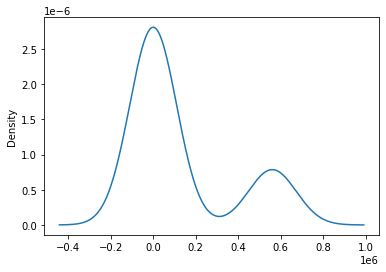

In [563]:
result.resid.plot(kind='kde')


In [564]:
model_result = model_result.reset_index()

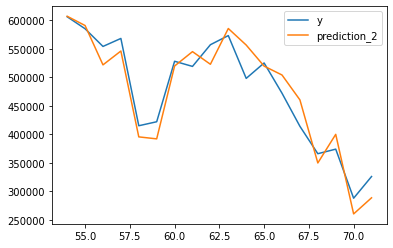

In [565]:
excog_fore = X_test[['PCA1','PCA2','PCA3']]
y_test['prediction_2']=pd.DataFrame(result.predict(start=len(X_train), end=len(pca_df[:-1]),exog=excog_fore))
result.summary()
y_test[['y','prediction_2']].plot()

model_result['prediction_2'] = y_test[['prediction_2']].reset_index(drop=True)
model_result['HomeSales_2'] = y_test[['y']].reset_index(drop=True)
#df2['Version'] = input("Version #")

In [569]:
model_result['M1 Diff'] = model_result['prediction_1']-model_result['HomeSales']
model_result['M1 % Diff'] = (model_result['prediction_1']-model_result['HomeSales'])/model_result['HomeSales']
model_result['M2 Diff'] = model_result['prediction_2']-model_result['HomeSales']
model_result['M2 % Diff'] = (model_result['prediction_2']-model_result['HomeSales'])/model_result['HomeSales']
model_result = model_result.rename(columns = {'index': 'Date'})

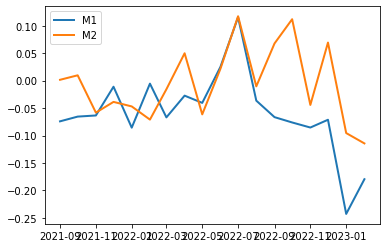

In [571]:
fig, ax = plt.subplots()

ax.plot(model_result['Date'],model_result['M1 % Diff'],linewidth=2.0,label='M1')
ax.plot(model_result['Date'],model_result['M2 % Diff'],linewidth=2.0,label='M2')
legend = plt.legend()

In [546]:
model_result

,Date,Date,HomeSales,prediction_1,prediction_2,HomeSales_2,M1 Diff,M1 % Diff,M2 Diff,M2 % Diff
0,0,2021-09-01,606000.0,561038.490236,606904.133839,606000.0,-44961.509764,-0.074194,904.133839,0.001492
1,1,2021-10-01,585000.0,546644.130232,590660.607009,585000.0,-38355.869768,-0.065566,5660.607009,0.009676
2,2,2021-11-01,554000.0,518817.399334,521692.564460,554000.0,-35182.600666,-0.063506,-32307.435540,-0.058317
3,3,2021-12-01,568000.0,561680.915815,545972.941818,568000.0,-6319.084185,-0.011125,-22027.058182,-0.038780
4,4,2022-01-01,415000.0,379431.003397,395483.929288,415000.0,-35568.996603,-0.085708,-19516.070712,-0.047027
5,5,2022-02-01,422000.0,419679.376805,392019.904735,422000.0,-2320.623195,-0.005499,-29980.095265,-0.071043
6,6,2022-03-01,528000.0,492635.211820,519679.480747,528000.0,-35364.788180,-0.066979,-8320.519253,-0.015759
7,7,2022-04-01,519000.0,504796.462293,544869.688174,519000.0,-14203.537707,-0.027367,25869.688174,0.049845
8,8,2022-05-01,557000.0,534395.382306,522738.348043,557000.0,-22604.617694,-0.040583,-34261.651957,-0.061511
9,9,2022-06-01,573000.0,587382.159160,585407.662351,573000.0,14382.159160,0.025100,12407.662351,0.021654


In [ ]:
path = "HomeSalesData.xlsx"
book = load_workbook(path)
writer = pd.ExcelWriter("HomeSalesData.xlsx", engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}


df2.to_excel(writer, startrow=writer.sheets['Main'].max_row, index = False,header= False)

# SANDBOX BELOW

In [113]:
from pandas.tseries.offsets import DateOffset
final_na = final.dropna()
months = (datetime.datetime(2023,12,1).year -final_na.index.max().year) * 12 + (datetime.datetime(2023,12,1).month -final_na.index.max().month)
new_dates=[final.index[-1]+DateOffset(months=x) for x in range(1,months)]
df_pred=pd.DataFrame(index=new_dates,columns =df.columns)
df2=pd.concat([final,df_pred])
df2[['HomeSales','Rates','PendingLists','NewComps','MedDayOnMar','MedHomeSalePrice']].tail(24)

,HomeSales,Rates,PendingLists,NewComps,MedDayOnMar,MedHomeSalePrice
2021-12-01,568000.0,3.0980,509648.0,127300.0,56.0,410000.0
2022-01-01,415000.0,3.4450,445895.0,87100.0,61.0,430500.0
2022-02-01,422000.0,3.7625,493215.0,98600.0,45.0,427400.0
2022-03-01,528000.0,4.1720,524911.0,112700.0,36.0,435900.0
2022-04-01,519000.0,4.9825,559294.0,107400.0,32.0,458200.0
2022-05-01,557000.0,5.2300,565274.0,120900.0,30.0,450700.0
2022-06-01,573000.0,5.5220,547478.0,122400.0,31.0,432700.0
2022-07-01,498000.0,5.4125,506297.0,123500.0,36.0,478200.0
2022-08-01,525000.0,5.2225,491261.0,122200.0,43.0,440300.0
2022-09-01,472000.0,6.1120,468475.0,120400.0,49.0,477700.0


In [ ]:
df2.MedHomeSalePrice.tail(24)

In [ ]:
#Baseline predictions
base_rate = pd.Series([6.665,6.735,6.858,6.924,6.831,
                      6.724,6.865,6.780,6.863,6.994,
                      6.891,7.141,7.274,7.269,7.132])
base_newcomps= pd.Series([118573,121813,109300,110545,117101,
                    102152,116464,123476,123322,120050,
                    111506,121495,109394,119341,106409])
base_PL = pd.Series([457252,447679,435222,476934,486518,
                    510398,543869,553113,547221,496375,
                    495135,475412,425538,437679,409432])
base_MDOM = pd.Series([57,59,67,65,59,
                      55,48,44,45,49,
                      51,55,59,62,69])
base_MHSP = pd.Series([465000,443000,438000,423000,435000,
                     445000,438900,442000,434000,423980,
                     410300,419000,413000,406900,404500])

In [ ]:

ratefill = pd.Series([6.665,6.735,6.858,6.924,6.831,
                      6.724,6.865,6.780,6.863,6.994,
                      6.891,7.141,7.274,7.269,7.132])
NewCompsfill = pd.Series([118573,121813,109300,110545,117101,
                    102152,116464,123476,123322,120050,
                    111506,121495,109394,119341,106409])
PLfill = pd.Series([457252,447679,435222,476934,486518,
                    510398,543869,553113,547221,496375,
                    495135,475412,425538,437679,409432])
MDOMfill = pd.Series([57,59,67,65,59,
                      55,48,44,45,49,
                      51,55,59,62,69])
MHSPfill = pd.Series([465000,443000,438000,423000,435000,
                     445000,438900,442000,434000,423980,
                     410300,419000,413000,406900,404500])

df2['Rates'].iloc[-15:] = ratefill
df2['NewComps'].iloc[-15:] = NewCompsfill
df2['PendingLists'].iloc[-15:] = PLfill
df2['MedDayOnMar'].iloc[-15:] = MDOMfill
df2['MedHomeSalePrice'].iloc[-15:] = MHSPfill
df2['Actual/Estimate'] = pd.Series()
df2['Actual/Estimate'].iloc[-15:] = 'Estimate'
df2['Actual/Estimate'].iloc[:-15] = 'Actual'

In [ ]:
df2[['HomeSales','Rates','PendingLists','NewComps','MedDayOnMar','MedHomeSalePrice']].tail(24)

In [ ]:
df2.loc['2019-01-01':'2023-12-01',['Rates','PendingLists','NewComps','MedDayOnMar','HomeSales','predictions']]

In [ ]:

HomeSales

In [ ]:
client = bigquery.Client(project='porch-prod')
table_id = "porch-prod.sandbox.total_home_sales"
dataframe = HomeSales
job_config = bigquery.LoadJobConfig(
    # Specify a (partial) schema. All columns are always written to the
    # table. The schema is used to assist in data type definitions.
    schema=[
        # Specify the type of columns whose type cannot be auto-detected. For
        # example the "title" column uses pandas dtype "object", so its
        # data type is ambiguous.
        bigquery.SchemaField("HomeSales", bigquery.enums.SqlTypeNames.INT64),
        # Indexes are written if included in the schema by name.
        bigquery.SchemaField("Date", bigquery.enums.SqlTypeNames.DATE),
    ],
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE write
    # disposition it replaces the table with the loaded data.
    write_disposition="WRITE_TRUNCATE",
)

job = client.load_table_from_dataframe(
    dataframe, table_id, job_config=job_config
)  # Make an API request.
job.result()  # Wait for the job to complete.

table = client.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

In [ ]:
df2[['HomeSales','predictions']].tail(24)

In [ ]:
#Pull in new variables

UnEm25Up = pd.read_excel('Unemploy25Up.xls')
PendLists = pd.read_excel('PendingListingUnits.xls')
NewStarts = pd.read_excel('NewStartedUnits.xls')
NewPermits = pd.read_excel('NewPermitUnits.xls')
NewConstructs = pd.read_excel('NewConstructionUnits.xls')
NewCompletes = pd.read_excel('NewCompleteUnits.xls')
CPIGrowth = pd.read_excel('CPIGrowthPrevMonth.xls')
CaseSchiller = pd.read_excel('CaseSchullerIndex.xls')
ActiveLists = pd.read_excel('ActiveListingUnits.xls')

new_features = pd.merge(UnEm25Up,PendLists)
new_features = new_features.merge(NewStarts)
new_features = new_features.merge(NewPermits)
new_features = new_features.merge(NewConstructs)
new_features = new_features.merge(NewCompletes)
new_features = new_features.merge(CPIGrowth)
new_features = new_features.merge(CaseSchiller)
new_features = new_features.merge(ActiveLists)
new_features

In [ ]:
newDF = df.merge(new_features, left_on='date',right_on='observation_date')
newDF = newDF.set_index(pd.to_datetime(newDF['Date']))

In [ ]:

X_DF = newDF[['Rates', 'PendingListingUnits', 'NewStartedUnits_K',
       'NewPermitsIssued_K', 'NewConstructionUnits_K', 'NewCompletedUnits_K',
       'CaseSchulerIndex', 'ActiveListingUnits']]
X_DF_shift = newDF[['Rates', 'PendingListingUnits', 'NewStartedUnits_K',
       'NewPermitsIssued_K', 'NewConstructionUnits_K', 'NewCompletedUnits_K',
       'CaseSchulerIndex','ActiveListingUnits']].shift(periods=1)
X_DF_shift2 = newDF[['Rates', 'PendingListingUnits', 'NewStartedUnits_K',
       'NewPermitsIssued_K', 'NewConstructionUnits_K', 'NewCompletedUnits_K',
       'CaseSchulerIndex','ActiveListingUnits']].shift(periods=2)
X_DF_shift = X_DF_shift.add_prefix('lag_').dropna()
X_DF_shift2 = X_DF_shift2.add_prefix('lag2_').dropna()
X = pd.merge(X_DF,X_DF_shift,on='Date')
X = X.merge(X_DF_shift2,on='Date').dropna()
y = newDF['Home Sales'][2:].values
model = RandomForestRegressor(n_estimators=1000, random_state=1)
model.fit(X, y)
print(model.feature_importances_)
# plot importance scores
names = names = X.columns.values
ticks = [i for i in range(len(names))]
plot = plt.figure(figsize=(12,9))
plot = plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names,rotation=45)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

X = final[['Rates','PendingLists','ActiveLists','NewComps','NewConst','NewPerms','NewStarts']]
X_lag1 = X.shift(1)
X_lag2 = X.shift(2)
X = X.merge(X_lag1, left_index=True,right_index=True)
X = X.merge(X_lag2, left_index=True,right_index=True).dropna()
y = final[['HomeSales']][2:]
model = RandomForestRegressor(n_estimators=1000, random_state=1)
model.fit(X, y)
print(model.feature_importances_)
# plot importance scores
names = names = X.columns.values
ticks = [i for i in range(len(names))]
plot = plt.figure(figsize=(12,9))
plot = plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names,rotation=45)

In [ ]:
newDF['PendingListingUnits'].plot()
result=adfuller(newDF['PendingListingUnits'].dropna())
result

newDF['Pending1D'] = newDF['PendingListingUnits'] - newDF['PendingListingUnits'].shift(1)
result=adfuller(newDF['Pending1D'].dropna())
result

newDF['Pending2D'] = newDF['Pending1D'] - newDF['Pending1D'].shift(1)
newDF['Pending2D'].plot()
result=adfuller(newDF['Pending2D'].dropna())
result


In [ ]:
newDF['NewConstructionUnits_K'].plot()
result=adfuller(newDF['NewConstructionUnits_K'].dropna())
result

newDF['NewCon1D'] = newDF['NewConstructionUnits_K'] - newDF['NewConstructionUnits_K'].shift(1)
result=adfuller(newDF['NewCon1D'].dropna())
result

newDF['NewCon2D'] = newDF['NewCon1D'] - newDF['NewCon1D'].shift(1)
result=adfuller(newDF['NewCon2D'].dropna())
result

newDF['NewCon3D'] = newDF['NewCon2D'] - newDF['NewCon2D'].shift(1)
newDF['NewCon3D'].plot()
result=adfuller(newDF['NewCon3D'].dropna())
result


In [ ]:
newDF['ActiveListingUnits'].plot()
result=adfuller(newDF['ActiveListingUnits'].dropna())
result

newDF['Active1D'] = newDF['ActiveListingUnits'] - newDF['ActiveListingUnits'].shift(1)
result=adfuller(newDF['Active1D'].dropna())
result


newDF['Active2D'] = newDF['Active1D'] - newDF['Active1D'].shift(1)
newDF['Active2D'].plot()
result=adfuller(newDF['Active2D'].dropna())
result


In [ ]:
newDF['CaseSchulerIndex'].plot()
result=adfuller(newDF['CaseSchulerIndex'].dropna())
result

newDF['CSIndex1D'] = newDF['CaseSchulerIndex'] - newDF['CaseSchulerIndex'].shift(1)
result=adfuller(newDF['CSIndex1D'].dropna())
result

newDF['CSIndex2D'] = newDF['CSIndex1D'] - newDF['CSIndex1D'].shift(1)
result=adfuller(newDF['CSIndex2D'].dropna())
result

newDF['CSIndex3D'] = newDF['CSIndex2D'] - newDF['CSIndex2D'].shift(1)
newDF['CSIndex3D'].plot()
result=adfuller(newDF['CSIndex3D'].dropna())
result


In [ ]:
arr1 = np.array(X_DF_shift[['Rates','Unemploy25UpCollege', 'PendingListingUnits', 'NewStartedUnits_K',
       'NewPermitsIssued_K', 'NewConstructionUnits_K', 'NewCompletedUnits_K',
       'ConsumerPriceGrowthPrevMonth', 'CaseSchulerIndex',
       'ActiveListingUnits']]).reshape(-1,10)
arr2 = y.reshape(-1,1)
stepwise_fit = auto_arima(arr2,arr1, start_p = 0, start_q = 0,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
stepwise_fit.summary()

## Archived Code Below in Markdown

#Pull in housing data from excel file
df = pd.read_excel('30yr_pmmsmnth.xls',sheet_name='Final',parse_dates= {"date" : ["Year","Month"]})
df = df.set_index('date')
df = df.sort_index()
rolling = df['Home Sales'].rolling(11)
df['MA'] = rolling.mean()

#Plot Sales, Rates and the Moving Average of Sales
df.Rates.plot(grid=True, label="rates", legend=True)
df['Home Sales'].plot(secondary_y=True, label="home sales", legend=True)
df['MA'].plot(secondary_y=True, label="MA", legend=True)

result=adfuller(df['Home Sales'])
result

df['1Difference'] = df['Home Sales'] - df['Home Sales'].shift(1)
result=adfuller(df['1Difference'].dropna())
result

df['2Difference'] = df['1Difference'] - df['1Difference'].shift(1)
result=adfuller(df['2Difference'].dropna())
df['2Difference'].plot()
result


df['SeasonalDiff'] = df['Home Sales'] - df['Home Sales'].shift(3)
#df['SeasonalDiff'].plot(label='0d')
#result=adfuller(df['SeasonalDiff'].dropna())
#result
df['1SeasonalDiff'] = df['SeasonalDiff']-df['SeasonalDiff'].shift(1)
df['1SeasonalDiff'].plot(label='1d')
result=adfuller(df['1SeasonalDiff'].dropna())
result

result=adfuller(df['Rates'].dropna())
df['1RateDiff'] = df['Rates']-df['Rates'].shift(1)
df['1RateDiff'].plot(label='1d')
result=adfuller(df['1RateDiff'].dropna())
result

#result=adfuller(df['Inventory'].dropna())
df['1InvDiff'] = df['Inventory']-df['Inventory'].shift(1)
#df['1InvDiff'].plot(label='1d')
#result=adfuller(df['1InvDiff'].dropna())
df['2InvDiff'] = df['1InvDiff']-df['1InvDiff'].shift(1)
df['2InvDiff'].plot(label='1d')
result=adfuller(df['2InvDiff'].dropna())
result

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig1=plot_acf(df['2Difference'].dropna())
fig2=plot_pacf(df['2Difference'].dropna())

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig1=plot_acf(df['1SeasonalDiff'].dropna())
fig2=plot_pacf(df['1SeasonalDiff'].dropna())

In [ ]:
arr1 = np.array(df[['Rates']]).reshape(-1,1)
arr2 = np.array(df['Home Sales']).reshape(-1,1)
stepwise_fit = auto_arima(arr2,arr1, start_p = 0, start_q = 0,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
stepwise_fit.summary()